## Introduction and Initialization
This sheet is designed to introduce the instruments used in this lab class and their associated control commands. It can be used initially for understanding the basic functionalities and command structures, but can also be used as a reference throughout the lab class for the control functions used over the whole class.

The below 2 cells are used for the imports and initializations of the instruments for the python document. Note that once a device is initilized, the communication port will only be addressable with this document's kernal. In order to use the instrument in a different document, you need to reset the kernal in the document the devices are initialized in.

In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\mqst_admin\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\mqst_admin\.qcodes\logs\240312-5772-qcodes.log


In [2]:
#Initialize Instruments:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed to 500 MHz
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')
microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')

#Don't think this is at all nesissary
#station=qc.Station(pulse_blaster, lock_in_amp, microwave_src)

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.34s
Connected to: None microwave_src (serial:None, firmware:None) in 5.11s


## Stanford Research Systems SR830 Lock In Amplifier Commands
The code blocks below show examples of how to control components of the SR830 LIA programatically.

In [ ]:
#This code brick shows how to programmatically change the time constant and sensativity settings found in the top left corner of the LIA interface

#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant(3) #This can be set to s, ms, us, or ns with leading numbers of 1, 3, or 5. E.g. 30ns is 30e-9 or 5ms is 5e-3.
print(f"Time constant = {lock_in_amp.time_constant()}")

# 'a', 'a-b', 'I 1M', 'I 100M' -> a for voltage, I 1M or I 100M for current. NOTE: You will largely be using the voltage mode.
lock_in_amp.input_config('a')

#When setting amps:
#lock_in_amp.sensitivity(50e-12) #uA, nA, pA, fA, or aA with leading number 1, 2, or 5. E.g. 200 fA is 200e-15 or 1uA is 1e-6
#When setting volts:
lock_in_amp.sensitivity(5e-6) #V, mV, uV, nV, or pV with leading number 1, 2, or 5. E.g. 200 nV is 200e-9 or 1mV is 1e-3
print(f"Sensitivity = {lock_in_amp.sensitivity()}")

In [ ]:
#This code brick shows how to retrieve values, as shown on the displays.

#'X', 'Y', 'R', and 'P' -> X, Y are cartesian representations, where as R and P are polar representations of the signal.
#NOTE: Even if a command is sent to read all 4 at the same time, R and P are given at different timings from X and Y, so the data that's retreived won't be synchronized.
print(lock_in_amp.snap("X", "Y", 'R', 'P'))
#Alternatively:
print(lock_in_amp.X()) #Cartesian Coordinate Geometry
print(lock_in_amp.Y()) #Cartesian Coordinate Geometry
print(lock_in_amp.R()) #Radial Polar Coordinate: R = sqrt(X^2 + Y^2)
lock_in_amp.P() #Phase Polar Coordinate: P = tan^-1(X/Y)
#NOTE: R will be sufficient for the experiments done in this lab.

In [ ]:
#This code brick shows how to adjust the reference settings found on the right side of the LIA interface.

#Reference Source is used to chose if the lock-in amplifier uses an internal reference source, set by the user between 1mHz and 102kHz, 
#or an external refference source through the "REF IN" input.
lock_in_amp.reference_source.set('internal') #'internal' for settable or 'external' for reading from the reference in channel.
lock_in_amp.frequency(12001) #Set the internal refference frequency (between 1e-3 and 102e3 Hz). Keep in mind that if this is set to external, this won't visially change anything.
print(lock_in_amp.frequency()) #Retreives the current refrence frequency.

#Set to external for use later in the document.
lock_in_amp.reference_source.set('external')

## PulseBlasterUSB Commands
The code blocks below show examples of how to control components of the PulseBlasterUSB programatically.

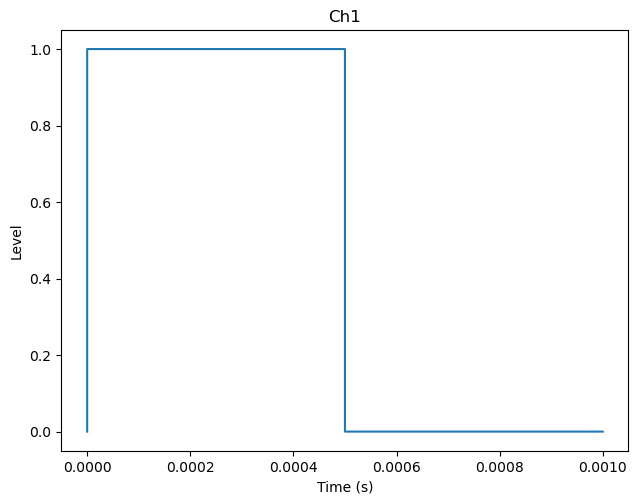

In [5]:
#You have access to channels 0-3 to pulse with. This allows you to control multiple devices with the same timing under PulseBlaster's internal reference clock.
ref_f = 200                           #The lock-in amplifier reference frequence.
ref_D = 0.5                           #The lock-in amplifier reference duty cycle.
T_ref_on = ref_D/ ref_f               #Gets the time for the active TTL signal
T_ref_off = (1 - ref_D)/ ref_f        #Gets the time for the inactive TTL signal
pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
pulse_blaster.ch1.pulse_sequence_buffer.set( #Note that ch0 indicates the bit this is programming to. Use ch0, ch1, ch2, or ch3 for the respective bits when prograqmming.
    [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
)                                     #Define the new pulse sequence
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.

Now plug your bit 0 input into the oscilliscope and run this code block. You should see the active TTL signal on the device.

In [6]:
pulse_blaster.flush_channel_buffer()

Now plug bit 0 back into the REF IN input of the Lock-In Amplifier and observe the reference frequency. To stop the TTL signal, run the code block below.

In [7]:
pulse_blaster.stop()

0

Keep in mind that once flushed, the PulseBlaster will continue to send out the provided pulse sequence until either the device is turned off or the stop() command is run as above, even if the kernal is reset.

## MG3681A Digital Modulation Signal Generator Commands
The code blocks below show examples of how to control components of the MG3681A programatically.

Note: DO NOT turn the RF output on without the RF output plugged into the RF coil, or you will likely break the MG3681A's amplifiers from RF back reflection.

In [ ]:
microwave_src.output_level_unit('dBm') #Sets the units of the output level to dBm
microwave_src.IQ_modulation('EXT') #Sets the I/Q channels to be controllable by external devices. In our case, the TTL pulses from the PulseBlaster.

You should see on the device screen at the top of the black box 3 settings. These should be:<br>
baseband: [Off]<br>I/Q Mod: [EXT]<br>Pulse Mod: [Off]

Run the code block below to set and retreive the frequency. This should be $\leq$ 3 GHz

In [ ]:
microwave_src.frequency(2.87e9)  #Sets the RF frequency
microwave_src.power(-3) #Sets the power in dBm
microwave_src.ask('FREQ?') #used to querey the current frequency setting.

In [ ]:
microwave_src.output('OFF') #microwave_src.output('ON') to turn on the RF output channel.

## KD300SP Programmable DC Power Supply Commands
The code blocks below show examples of how to control components of the KD300SP programatically.<br>
NOTE: You will not need this device until lab 2. You can skip this section if the KD300SP isn't attached to the magnets yet.

In [ ]:
#Initializes device.
dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')

Changes the voltage and current set point.

In [ ]:
dc_supply.ch1.voltage_setpoint(0) #Sets voltage
dc_supply.ch1.current_setpoint(0) #Sets current.

In [ ]:
dc_supply.ch1.voltage_setpoint(1) #Sets voltage
dc_supply.ch1.current_setpoint(1) #Sets current.

In the above segment, we set the voltage to 1V and attempted to set the current to 1A. However, as we can see on the display, the current was set to 0.292A. This is because the voltage is set as an anchor for the system, as it is now in constant 

In [ ]:
dc_supply.ch1.current_setpoint(0.2) #Sets maximum current.
dc_supply.ch1.voltage_setpoint(12) #Sets desired voltage

Similar to the constant voltage, if you are setting voltage, you can't surpass a certain threshhold, or else the system will chose a suitable value of voltage to use which keeps us at the constant ampierage. This is contant current mode (C. C).

In [ ]:
dc_supply.ch1.voltage_setpoint(0) #Sets desired voltage
dc_supply.ch1.current_setpoint(0) #Sets desired current.